In [56]:
# -------------------------------
# Import Libraries
# -------------------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# -------------------------------
# Load Dataset Robustly
# -------------------------------
df = pd.read_csv('/kaggle/input/microsoftstock/MicrosoftStock.csv')
df.columns = df.columns.str.strip()  # Remove extra spaces

# Detect Date column automatically
date_column = None
for col in df.columns:
    if 'date' in col.lower():
        date_column = col
        break
if date_column is None:
    raise KeyError("No column with 'Date' found in the dataset!")

df[date_column] = pd.to_datetime(df[date_column])
df.set_index(date_column, inplace=True)
print(f"Using '{date_column}' as Date index.")

# Detect Close column automatically
close_column = None
for col in df.columns:
    if 'close' in col.lower():
        close_column = col
        break
if close_column is None:
    raise KeyError("No column with 'Close' found in the dataset!")

print(f"Using '{close_column}' as Close price column.")
print(df.head())
print(df.info())


Using 'date' as Date index.
Using 'close' as Close price column.
             index   open   high    low  close    volume  Name
date                                                          
2013-02-08  390198  27.35  27.71  27.31  27.55  33318306  MSFT
2013-02-11  390199  27.65  27.92  27.50  27.86  32247549  MSFT
2013-02-12  390200  27.88  28.00  27.75  27.88  35990829  MSFT
2013-02-13  390201  27.93  28.11  27.88  28.03  41715530  MSFT
2013-02-14  390202  27.92  28.06  27.87  28.04  32663174  MSFT
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1259 entries, 2013-02-08 to 2018-02-07
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   index   1259 non-null   int64  
 1   open    1259 non-null   float64
 2   high    1259 non-null   float64
 3   low     1259 non-null   float64
 4   close   1259 non-null   float64
 5   volume  1259 non-null   int64  
 6   Name    1259 non-null   object 
dtypes: float64(4), int64(2), object(

In [57]:
# -------------------------------
# Step 2: Data Preprocessing
# -------------------------------

# 1. Handle missing values
df = df.interpolate()

# 2. Feature Engineering
# Simple Moving Average (SMA)
df['SMA_20'] = df[close_column].rolling(window=20).mean()
# Exponential Moving Average (EMA)
df['EMA_20'] = df[close_column].ewm(span=20, adjust=False).mean()
# Bollinger Bands
df['BB_upper'] = df['SMA_20'] + 2*df[close_column].rolling(20).std()
df['BB_lower'] = df['SMA_20'] - 2*df[close_column].rolling(20).std()
# RSI
delta = df[close_column].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
RS = gain / loss
df['RSI'] = 100 - (100 / (1 + RS))

# Drop NaN rows from rolling calculations
df = df.dropna()

# 3. Normalize only numeric columns (exclude strings)
numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
# Exclude 'index' if it exists
numerical_cols = [col for col in numerical_cols if col != 'index']

scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled[numerical_cols] = scaler.fit_transform(df_scaled[numerical_cols])

# 4. Train-test split
train_size = int(len(df_scaled) * 0.8)
train_data = df_scaled[:train_size]
test_data = df_scaled[train_size:]

print("Training set shape:", train_data.shape)
print("Testing set shape:", test_data.shape)


Training set shape: (992, 12)
Testing set shape: (248, 12)


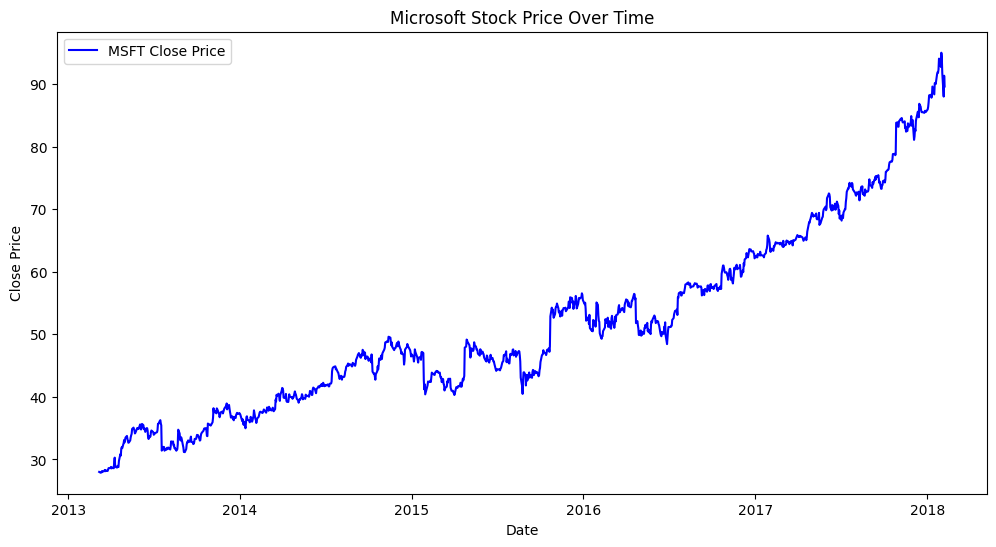

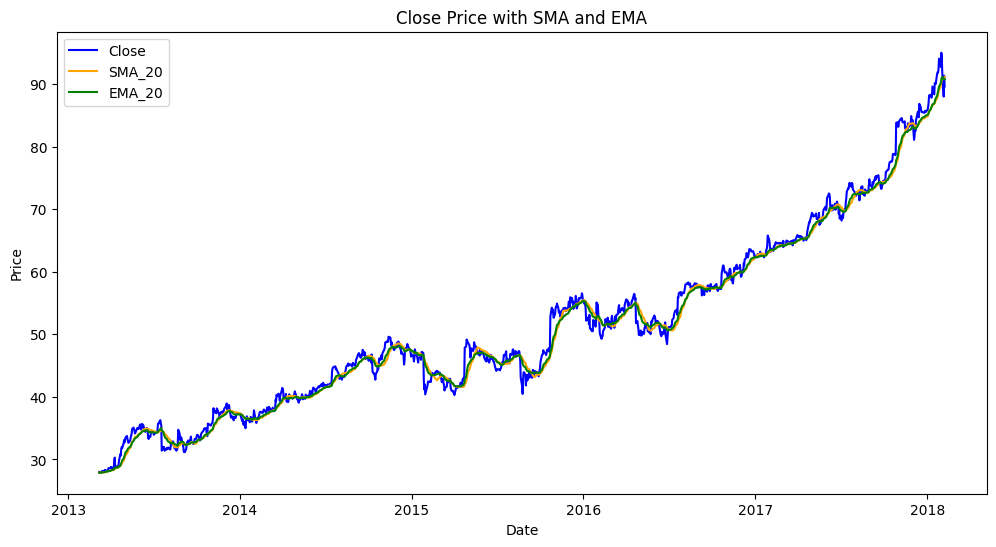

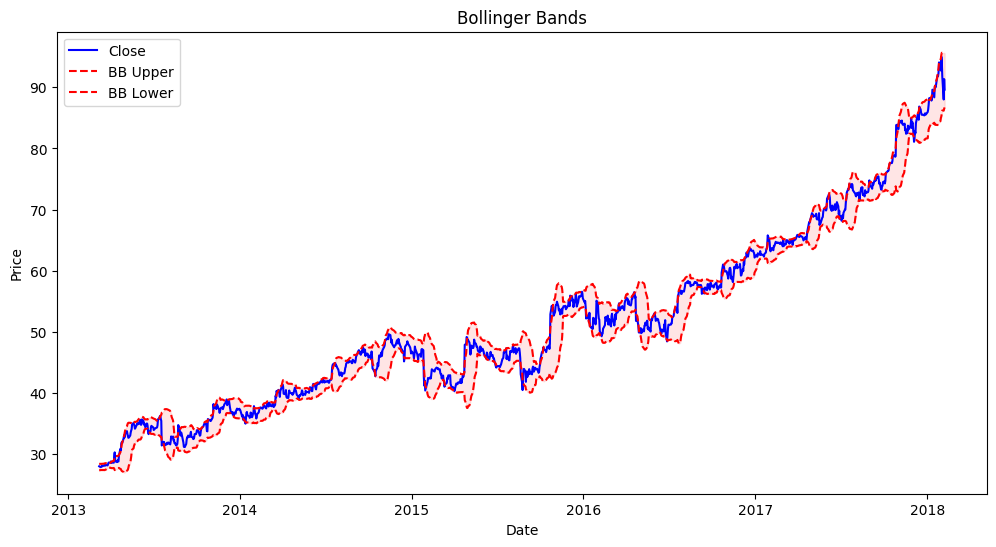

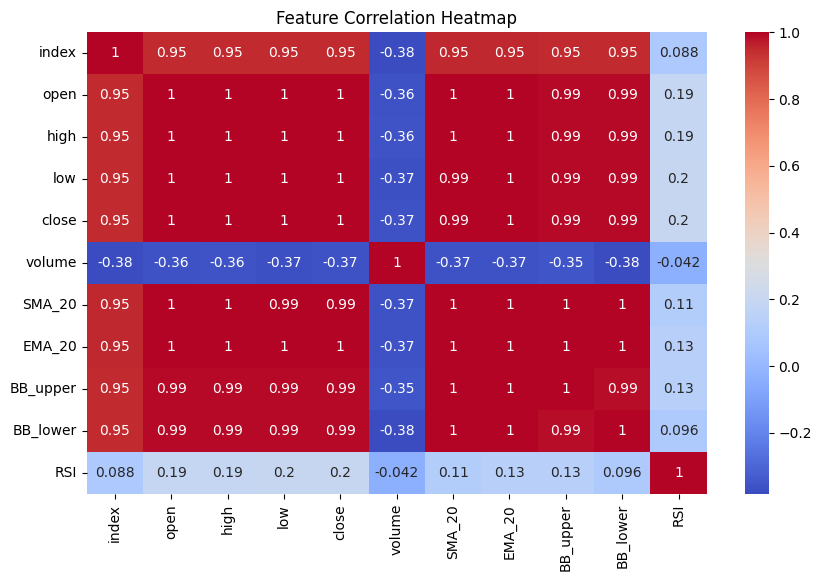

In [58]:
# -------------------------------
# Step 3: Exploratory Data Analysis
# -------------------------------

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Plot Microsoft stock price trend over time
plt.figure(figsize=(12,6))
plt.plot(df.index, df[close_column], label='MSFT Close Price', color='blue')
plt.title('Microsoft Stock Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

# 2. Plot SMA, EMA, and Close price together
plt.figure(figsize=(12,6))
plt.plot(df.index, df[close_column], label='Close', color='blue')
plt.plot(df.index, df['SMA_20'], label='SMA_20', color='orange')
plt.plot(df.index, df['EMA_20'], label='EMA_20', color='green')
plt.title('Close Price with SMA and EMA')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 3. Bollinger Bands visualization
plt.figure(figsize=(12,6))
plt.plot(df.index, df[close_column], label='Close', color='blue')
plt.plot(df.index, df['BB_upper'], label='BB Upper', color='red', linestyle='--')
plt.plot(df.index, df['BB_lower'], label='BB Lower', color='red', linestyle='--')
plt.fill_between(df.index, df['BB_lower'], df['BB_upper'], color='red', alpha=0.1)
plt.title('Bollinger Bands')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# 4. Correlation heatmap (numeric columns only)
numeric_cols = df.select_dtypes(include=np.number)
plt.figure(figsize=(10,6))
sns.heatmap(numeric_cols.corr(), annot=True, cmap='coolwarm')
plt.title('Feature Correlation Heatmap')
plt.show()


Linear Regression --> MAE: 0.0095, RMSE: 0.0120, R²: 0.9904
Random Forest --> MAE: 0.1573, RMSE: 0.1982, R²: -1.6140
XGBoost --> MAE: 0.1579, RMSE: 0.1979, R²: -1.6071


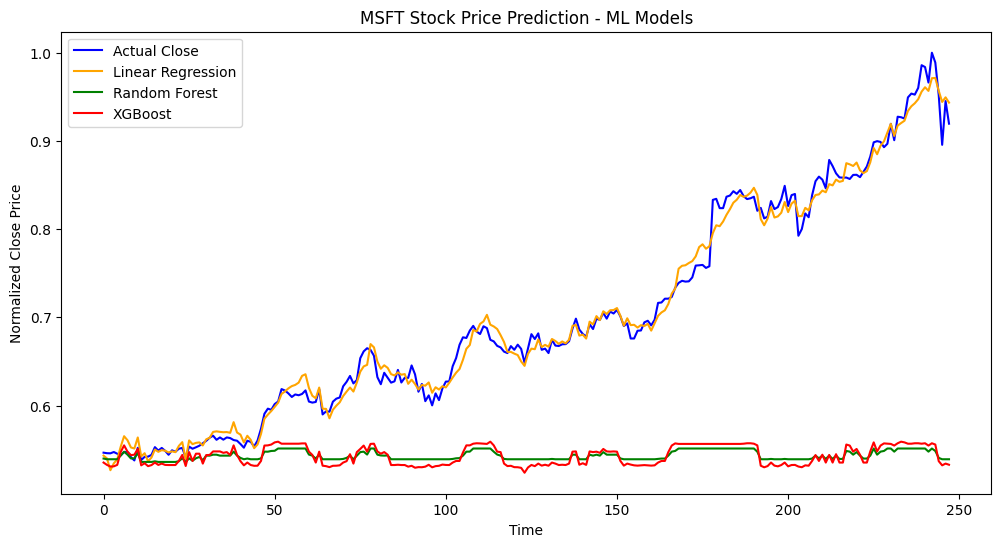

In [59]:
# -------------------------------
# Step 4.1: Machine Learning Models
# -------------------------------

# Features: numeric technical indicators only
features = ['SMA_20', 'EMA_20', 'BB_upper', 'BB_lower', 'RSI']

X_train = train_data[features]
y_train = train_data[close_column]
X_test = test_data[features]
y_test = test_data[close_column]

# --- Linear Regression ---
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)

# --- Random Forest ---
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

# --- XGBoost ---
xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)

# Function to evaluate models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} --> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R²: {r2:.4f}")

# Evaluate all models
evaluate_model(y_test, y_pred_lr, "Linear Regression")
evaluate_model(y_test, y_pred_rf, "Random Forest")
evaluate_model(y_test, y_pred_xgb, "XGBoost")

# Plot predictions vs actual
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label='Actual Close', color='blue')
plt.plot(y_pred_lr, label='Linear Regression', color='orange')
plt.plot(y_pred_rf, label='Random Forest', color='green')
plt.plot(y_pred_xgb, label='XGBoost', color='red')
plt.title('MSFT Stock Price Prediction - ML Models')
plt.xlabel('Time')
plt.ylabel('Normalized Close Price')
plt.legend()
plt.show()


Epoch 1/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 9s 71ms/step - loss: 0.0202
Epoch 2/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 63ms/step - loss: 0.0021
Epoch 3/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0012
Epoch 4/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 0.0012
Epoch 5/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step - loss: 9.2957e-04
Epoch 6/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 0.0011
Epoch 7/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 75ms/step - loss: 9.1405e-04
Epoch 8/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 8.9137e-04
Epoch 9/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 7.9644e-04
Epoch 10/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 65ms/step - loss: 8.6053e-04
Epoch 11/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 3s 67ms/step - loss: 8.4718e-04
Epoch 12/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 69ms/step - loss: 6.1636e-04
Epoch 13/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 67ms/step - loss: 6.5241e-04
Epoch 14/50
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 66ms/step - loss: 5.9583e-04
Epoch 15/50
30/30 ━━━━━━━━━━━━━━━━━

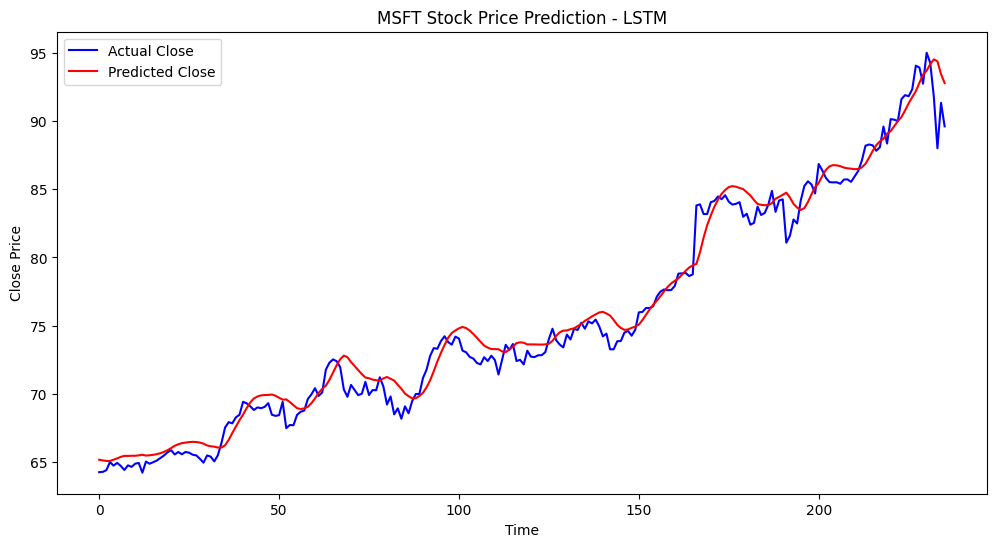

In [60]:
# -------------------------------
# Step 4.2: LSTM Model
# -------------------------------

# Normalize close price only for LSTM
close_values = df[close_column].values.reshape(-1,1)
scaler_close = MinMaxScaler()
scaled_close = scaler_close.fit_transform(close_values)

# Function to create sequences
def create_sequences(data, seq_length=60):
    X, y = [], []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

seq_length = 60
X_lstm, y_lstm = create_sequences(scaled_close, seq_length)

# Train-test split
train_size = int(len(X_lstm) * 0.8)
X_train_lstm, X_test_lstm = X_lstm[:train_size], X_lstm[train_size:]
y_train_lstm, y_test_lstm = y_lstm[:train_size], y_lstm[train_size:]

# Reshape for LSTM [samples, time steps, features]
X_train_lstm = X_train_lstm.reshape((X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_lstm = X_test_lstm.reshape((X_test_lstm.shape[0], X_test_lstm.shape[1], 1))

# Build LSTM model
lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(X_train_lstm.shape[1],1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

lstm_model.compile(optimizer='adam', loss='mean_squared_error')
lstm_model.fit(X_train_lstm, y_train_lstm, batch_size=32, epochs=50)

# Predict
y_pred_lstm = lstm_model.predict(X_test_lstm)
y_pred_lstm = scaler_close.inverse_transform(y_pred_lstm)
y_test_actual = scaler_close.inverse_transform(y_test_lstm.reshape(-1,1))

# Evaluate LSTM
evaluate_model(y_test_actual, y_pred_lstm, "LSTM")

# Plot LSTM predictions
plt.figure(figsize=(12,6))
plt.plot(y_test_actual, label='Actual Close', color='blue')
plt.plot(y_pred_lstm, label='Predicted Close', color='red')
plt.title('MSFT Stock Price Prediction - LSTM')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━

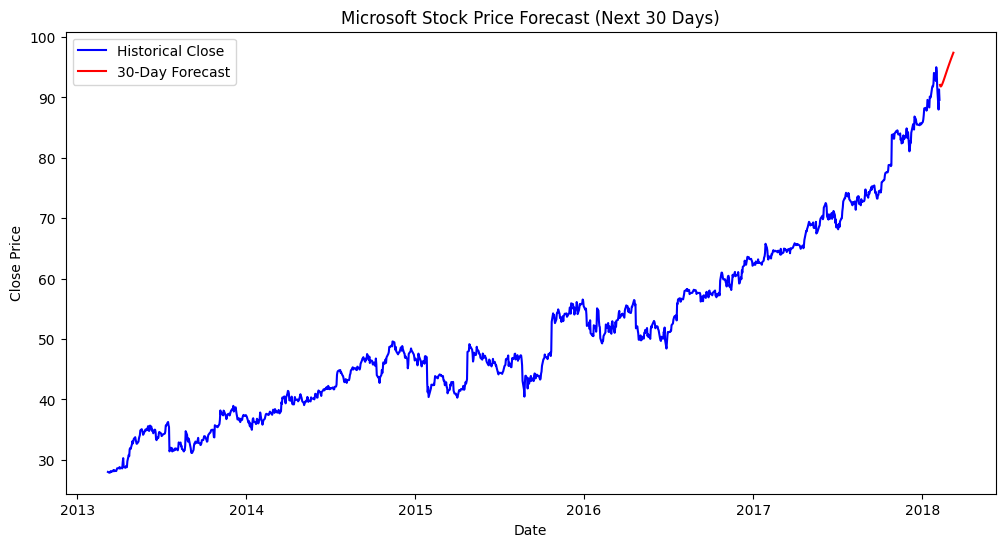

In [61]:
# Get last 60 days from the scaled close price
last_60_days = scaled_close[-60:]
forecast_input = last_60_days.reshape(1, 60, 1)

# Store predictions
predictions = []

for _ in range(30):
    # Predict the next day
    next_pred = lstm_model.predict(forecast_input)
    predictions.append(next_pred[0,0])
    
    # Reshape prediction to 3D (1,1,1) and append
    next_pred_reshaped = next_pred.reshape(1,1,1)
    forecast_input = np.append(forecast_input[:,1:,:], next_pred_reshaped, axis=1)

# Inverse transform to original scale
predictions_actual = scaler_close.inverse_transform(np.array(predictions).reshape(-1,1))

# Create dates for next 30 days
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=30)

# Plot forecast
plt.figure(figsize=(12,6))
plt.plot(df.index, df[close_column], label='Historical Close', color='blue')
plt.plot(future_dates, predictions_actual, label='30-Day Forecast', color='red')
plt.title('Microsoft Stock Price Forecast (Next 30 Days)')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()
